<a href="https://colab.research.google.com/github/amitkag85/CKAD-exercises/blob/master/2_Extending_our_MLP_to_be_conditional_on_logical_operators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Our goal is to extend our logical operation model in a couple ways:

1. make a single model that can handle `AND`, `OR`, and `XOR`, depending on which one we ask for.
2. make a model that will predict which logical operator was used, given the inputs and output.

The main concepts this will demonstrate are making a model **conditional**, and predicting **probability distributions**.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, Dataset

## Simple Model: Multilayer Perceptron

We'll define a simple multilayer perceptron ([MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) a.k.a. feedforward network) with one hidden layer. This will be a subclass of `torch.nn.Module`, which requires:
* `__init__` with a call to `super().__init__()`
* `forward()` which defines how to run the model given an input

We will use the container [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) to glue all of our layers into a single module that passes the output from the previous step as the input to the next. Note that you must ensure that the output dimensions of the previous layer match the input dimensions of the next.

The main component which makes neural networks able to learn non-linear functions are the [activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) places between the various layers. Since this model is very small and simple, we will be using [torch.nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid), which produces an "S curve" that squashes all values to the range 0.0 - 1.0.

In [2]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    self.fc = nn.Sequential(
        nn.Linear(self.input_dim, self.hidden_dim),
        nn.LeakyReLU(),
        nn.Linear(self.hidden_dim, self.output_dim),
        nn.Sigmoid()
    )

  def forward(self, x):
    # the `Sequential` can just be called on the input
    return self.fc(x)

## Device

Torch supports multiple backends, most notibly `'cpu'` and `'cuda'` (with experimental support for Apple Metal as well). The main thing to remember is that all `Module`s and `Tensor`s neeed to be on the same device when running, or else you will get an error. Also note that all everything initially begins on CPU when created (with the exception of models that were saved while on GPU, but let's ignore that for now).

In [3]:
# get the device we are using and save it for later. change the runtime
# to GPU to see if print `cuda`
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# create a tensor and send it to our device
x = torch.randn(2,3, device=device)
print(x)
# you can also send things to a device after they are creates
x = torch.randn(2, 3)
print(x)
x = x.to(device)
print(x)

# some operations, such as converting to a numpy array, require tensors
# to be on the CPU specifically, so using `.cpu()` is helpful
print(x.cpu().numpy())
# there is also `.cuda()` but that asumesthat you actually have a GPU

cpu
tensor([[ 0.0682,  0.8186, -0.1895],
        [ 1.0544,  1.8875, -0.5973]])
tensor([[ 1.5405,  0.5023,  0.7658],
        [-0.7287,  1.3163,  2.3349]])
tensor([[ 1.5405,  0.5023,  0.7658],
        [-0.7287,  1.3163,  2.3349]])
[[ 1.5404756   0.502259    0.76583356]
 [-0.72872007  1.3163453   2.3348758 ]]


## Dataset: Conditional Logic Operator



In [4]:
OPERATOR = {
    'AND': [1, 0, 0],
    'OR': [0, 1, 0],
    'XOR': [0, 0, 1]
}

class LogicDataset(Dataset):
  def __init__(self):
      pass

  def __len__(self):
    # return the number of training examples
    return len(self.x)

  def __getitem__(self, idx):
    # return the input/output for a given example (by index)
    op = OPERATOR[self.op]
    x = op + self.x[idx]
    y = self.y[idx]
    return {'x': torch.FloatTensor(x), 'y': torch.FloatTensor([y])}


class AndDataset(LogicDataset):
  def __init__(self):
    # example inputs
    self.op = 'AND'

    self.x = [
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1]
    ]
    # example outputs
    self.y = [
        0,
        0,
        0,
        1
    ]


class OrDataset(LogicDataset):
  def __init__(self):
    # example inputs
    self.op = 'OR'

    self.x = [
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1]
    ]
    # example outputs
    self.y = [
        0,
        1,
        1,
        1
    ]


class XorDataset(LogicDataset):
  def __init__(self):
    # example inputs
    self.op = 'XOR'

    self.x = [
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1]
    ]
    # example outputs
    self.y = [
        0,
        1,
        1,
        0
    ]

In [5]:
dataset = ConcatDataset([AndDataset(), OrDataset(), XorDataset()])
print(len(dataset))
for x in dataset:
  print(x)

12
{'x': tensor([1., 0., 0., 0., 0.]), 'y': tensor([0.])}
{'x': tensor([1., 0., 0., 1., 0.]), 'y': tensor([0.])}
{'x': tensor([1., 0., 0., 0., 1.]), 'y': tensor([0.])}
{'x': tensor([1., 0., 0., 1., 1.]), 'y': tensor([1.])}
{'x': tensor([0., 1., 0., 0., 0.]), 'y': tensor([0.])}
{'x': tensor([0., 1., 0., 1., 0.]), 'y': tensor([1.])}
{'x': tensor([0., 1., 0., 0., 1.]), 'y': tensor([1.])}
{'x': tensor([0., 1., 0., 1., 1.]), 'y': tensor([1.])}
{'x': tensor([0., 0., 1., 0., 0.]), 'y': tensor([0.])}
{'x': tensor([0., 0., 1., 1., 0.]), 'y': tensor([1.])}
{'x': tensor([0., 0., 1., 0., 1.]), 'y': tensor([1.])}
{'x': tensor([0., 0., 1., 1., 1.]), 'y': tensor([0.])}


## DataLoader and Batching



In [6]:
from torch.utils.data import DataLoader

batch_size = 12

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for batch in dataloader:
  x = batch['x']
  y = batch['y']
  print(x, 'x.size()', x.size())
  print(y, 'y.size()', y.size())

tensor([[1., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 0.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1.]]) x.size() torch.Size([12, 5])
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.]]) y.size() torch.Size([12, 1])


## Training Setup



In [7]:
from torch.optim import Adam
from tqdm import trange  # gives us a nice progress bar

epochs = 10000  # the number of times to iterate through the training data

model = MLP(5, 4, 1)  # create an instance of our model
model = model.to(device)  # send the model to the appropriate device
print(model.train())  # set the model to train mode (default) and print it for good measure
opt = Adam(model.parameters())  # initialize the optimizer with the model parameters
loss_fn = nn.MSELoss()  # create an instance of our loss function
losses = []  # create an empty list for tracking the loss every epoch

for epoch in trange(epochs):  # loop for the number of epochs
  for batch in dataloader:  # iterate through the dataset

    # get the inputs and target outputs and send them to the device
    x = batch['x'].to(device)
    y = batch['y'].to(device)

    # run the model and get its prediction
    y_hat = model(x)

    # calculate the loss
    loss = loss_fn(y_hat, y)

    # clear the previous gradient from the optimizer
    opt.zero_grad()
    # calculate the gradient based on the loss
    loss.backward()
    # update the model weights based on the gradient
    opt.step()

    '''
    Store the loss in a list so that we can plot it later.
    When doing so however, we need to call `.detach()` in
    order to remove the gradient, `.cpu()` to make sure it
    is on the CPU, and `.numpy()` to convert it into a numpy
    value because matplotlib doesn't work directly on tensors.
    '''
    losses.append(loss.detach().cpu().numpy())

MLP(
  (fc): Sequential(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


100%|██████████| 10000/10000 [00:18<00:00, 536.25it/s]


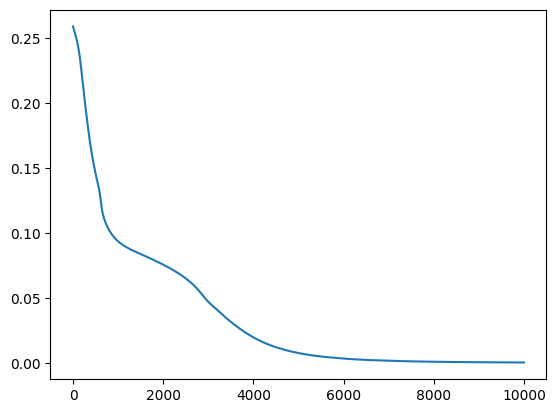

In [8]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

Since our training data is so small, we can iterate through all examples and compare the prediction to the target. For more complex datasets/tasks could use a test set to plot the validation loss, calculate a confusion matrix, etc.

In [ ]:
model = model.cpu()
model.eval()

with torch.no_grad():
  for i, example in enumerate(dataset):
    x = example['x']
    y = example['y']
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    print('x:', x, 'y:', y, 'y_hat:', y_hat, 'predicion:', y_hat.round(), 'loss:', loss)
    if i % 4 == 3:
      print('')

## Logic Operator Prediction



In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    self.fc = nn.Sequential(
        nn.Linear(self.input_dim, self.hidden_dim),
        nn.LeakyReLU(),
        nn.Linear(self.hidden_dim, self.output_dim)
    )

  def forward(self, x):
    # the `Sequential` can just be called on the input
    return self.fc(x)

In [ ]:
OPERATOR = {
    'AND': 0,
    'OR': 1,
    'XOR': 2
}

class LogicDataset(Dataset):
  def __init__(self):
      pass

  def __len__(self):
    # return the number of training examples
    return len(self.x)

  def __getitem__(self, idx):
    # return the input/output for a given example (by index)
    x = self.x[idx] + [self.y[idx]]
    y = OPERATOR[self.op]
    return {'x': torch.FloatTensor(x), 'y': torch.LongTensor([y])}


class AndDataset(LogicDataset):
  def __init__(self):
    # example inputs
    self.op = 'AND'

    self.x = [
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1]
    ]
    # example outputs
    self.y = [
        0,
        0,
        0,
        1
    ]


class OrDataset(LogicDataset):
  def __init__(self):
    # example inputs
    self.op = 'OR'

    self.x = [
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1]
    ]
    # example outputs
    self.y = [
        0,
        1,
        1,
        1
    ]


class XorDataset(LogicDataset):
  def __init__(self):
    # example inputs
    self.op = 'XOR'

    self.x = [
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1]
    ]
    # example outputs
    self.y = [
        0,
        1,
        1,
        0
    ]

In [ ]:
dataset = ConcatDataset([AndDataset(), OrDataset(), XorDataset()])
print(len(dataset))
for x in dataset:
  print(x)

## DataLoader and Batching



In [ ]:
from torch.utils.data import DataLoader

batch_size = 12

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for batch in dataloader:
  x = batch['x']
  y = batch['y']
  print(x, 'x.size()', x.size())
  print(y, 'y.size()', y.size())

## Training Setup



In [ ]:
from torch.optim import Adam
from tqdm import trange  # gives us a nice progress bar

epochs = 10000  # the number of times to iterate through the training data

model = MLP(3, 4, 3)  # create an instance of our model
model = model.to(device)  # send the model to the appropriate device
print(model.train())  # set the model to train mode (default) and print it for good measure
opt = Adam(model.parameters())  # initialize the optimizer with the model parameters
loss_fn = nn.CrossEntropyLoss()  # create an instance of our loss function
losses = []  # create an empty list for tracking the loss every epoch

for epoch in trange(epochs):  # loop for the number of epochs
  for batch in dataloader:  # iterate through the dataset

    # get the inputs and target outputs and send them to the device
    x = batch['x'].to(device)
    y = batch['y'].squeeze().to(device)

    # run the model and get its prediction
    y_hat = model(x)

    # calculate the loss
    loss = loss_fn(y_hat, y)

    # clear the previous gradient from the optimizer
    opt.zero_grad()
    # calculate the gradient based on the loss
    loss.backward()
    # update the model weights based on the gradient
    opt.step()

    '''
    Store the loss in a list so that we can plot it later.
    When doing so however, we need to call `.detach()` in
    order to remove the gradient, `.cpu()` to make sure it
    is on the CPU, and `.numpy()` to convert it into a numpy
    value because matplotlib doesn't work directly on tensors.
    '''
    losses.append(loss.detach().cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

Since our training data is so small, we can iterate through all examples and compare the prediction to the target. For more complex datasets/tasks could use a test set to plot the validation loss, calculate a confusion matrix, etc.

In [ ]:
model = model.cpu()
model.eval()

with torch.no_grad():
  for i, example in enumerate(dataset):
    x = example['x']
    y = example['y'].squeeze()
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    print('x:', x, 'y:', y, 'y_hat:', y_hat.softmax(dim=-1), 'predicion:', y_hat.argmax(dim=-1))
    if i % 4 == 3:
      print('')

In [ ]:
model = model.cpu()
model.eval()

xs = []
y_hats = []

with torch.no_grad():
  for example in dataset:
    x = example['x']
    y_hat = model(x)

    xs.append(x)
    y_hats.append(y_hat)

In [ ]:
fig, ax = plt.subplots(ncols=len(y_hats), sharey=True)

for i, x in enumerate(y_hats):
  ax[i].bar(range(3), y_hats[i].softmax(dim=-1))